In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

In [2]:
# read the sift vectors from the file
def read_sift_vectors(filename):
    sift_vectors = []
    x = 0
    # parse the file at paranthesis
    with open(filename, 'r') as f:
        # read first line of f
        line = f.readline()
        while line:
            temp_list = []
            line = line.strip()
            if line.startswith('['):
                while(not line.endswith(']\n')):
                    temp = line.replace('[', '')
                    temp = temp.replace(']', '')
                    temp = temp.replace('\n', '')
                    temp = temp[1:]
                    temp = temp.split(' ')
                    # remove empty strings
                    temp = list(filter(None, temp))
                    temp_list.extend(float(temp[i]) for i in range(len(temp)))
                    line = f.readline()
                temp = line.replace(']', '') 
                temp = temp.replace('\n', '')
                temp = temp[1:]
                temp = temp.split(' ')
                # remove empty strings
                temp = list(filter(None, temp))
                temp_list.extend(float(temp[i]) for i in range(len(temp)))


            # convert to numpy array
            # parse the list to get the float values
            temp_list = [float(i) for i in temp_list]
            temp_list = np.array(temp_list)
            sift_vectors.append(temp_list)
            line = f.readline()



    return np.array(sift_vectors)

In [48]:
sift_file = './image_words_sift.txt'

# read the sift vectors
sift_vectors = read_sift_vectors(sift_file)

In [51]:
def getFeatureVectors_sift(img, vocabulary):
    features = np.zeros(vocabulary.shape[0])
    sift = cv.SIFT_create()
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp = []
    des = []
    k = 60
    for l in range(img.shape[0]//k):
        for j in range(img.shape[1]//k):
            kp_block = sift.detect(gray[l*k:(l+1)*k,j*k:(j+1)*k], None)
            # extract only the strongest keypoints in each block
            kp_block = sorted(kp_block, key=lambda x: -x.response)[:1]
            # if there is no keypoint in the block, take the centre point as the keypoint
            if len(kp_block) == 0:
                kp_block = [cv.KeyPoint(l*k+k/2,j*k+k/2,k)]
            kp_block,des_block = sift.compute(gray[l*k:(l+1)*k,j*k:(j+1)*k],kp_block)

            # find minimum distance between the descriptors of the block and the vocabulary
            features[np.argmin([np.linalg.norm(des_block - v) for v in vocabulary])] += 1

    return features

In [52]:
image = cv.imread('./imgs/25.jpg')

# get the feature vectors
feature_vectors = getFeatureVectors_sift(image, sift_vectors)

In [54]:
sift_vectors_all = []

for i in range(len(os.listdir('./imgs'))):
    img = cv.imread('./imgs/'+os.listdir('./imgs')[i])
    sift_vectors_all.append(getFeatureVectors_sift(img, sift_vectors))

sift_vectors_all = np.array(sift_vectors_all)

# davg = np.mean(np.sum(sift_vectors_all, axis=1))

In [56]:
davg = np.mean(np.sum(sift_vectors_all, axis=1), axis = 0)

In [57]:
def tf_score(word, image, k1, b, davg, vocabulary):
    feat = getFeatureVectors_sift(image, vocabulary)
    tf = k1*feat[word] / (feat[word] + k1 * (1 - b + b * (np.sum(feat) / davg)))
    return tf

In [58]:
def idf_score(word, data_folder, sift_all):
    Dj = 0
    for i in range(len(sift_all)):
        if sift_all[i][word] > 0:
            Dj += 1

    D = len(os.listdir(data_folder))

    idf = np.log((D + 1) / (Dj + 0.5))
    return idf

In [59]:
tff = tf_score(0, image, 1.2, 0.75, 1, sift_vectors)

In [60]:
tff

0.02696629213483146

In [61]:
idf = idf_score(0, './imgs', sift_vectors_all)

In [62]:
idf

0.20706116296971042

In [63]:
def score(img1, img2, sift_all, vocabulary):
    score = 0
    for i in range(len(vocabulary)):
        score += tf_score(i, img1, 1.2, 0.75, davg, vocabulary) * idf_score(i, './imgs', sift_all) * tf_score(i, img2, 1.2, 0.75, davg, vocabulary) * idf_score(i, './imgs', sift_all)

    return score

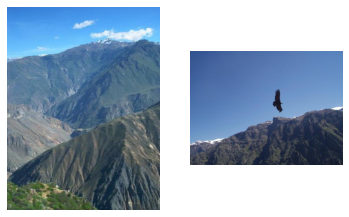

Score for both these images is:  1.635177102717352


In [64]:
img1 = cv.imread('./imgs/5152.jpg')
img2 = cv.imread('./imgs/5155.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

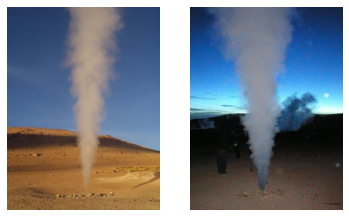

Score for both these images is:  2.571363630894358


In [65]:
img1 = cv.imread('./imgs/1877.jpg')
img2 = cv.imread('./imgs/1879.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

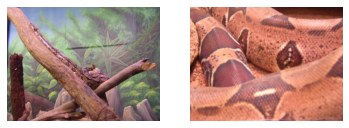

Score for both these images is:  0.9001321085250295


In [66]:
img1 = cv.imread('./imgs/3191.jpg')
img2 = cv.imread('./imgs/3193.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

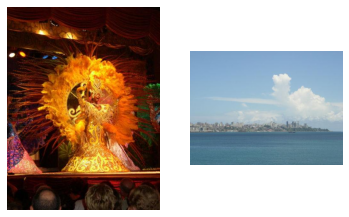

Score for both these images is:  0.5220803984221672


In [67]:
img1 = cv.imread('./imgs/3170.jpg')
img2 = cv.imread('./imgs/3208.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

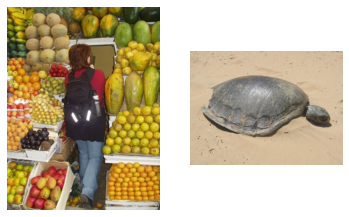

Score for both these images is:  0.5837724695469194


In [68]:
img1 = cv.imread('./imgs/3838.jpg')
img2 = cv.imread('./imgs/3318.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)